<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Функции-для-анализа-данных" data-toc-modified-id="Функции-для-анализа-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции для анализа данных</a></span></li><li><span><a href="#Загрузим-данные" data-toc-modified-id="Загрузим-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузим данные</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression-Модель" data-toc-modified-id="Linear-Regression-Модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression Модель</a></span></li><li><span><a href="#RandomizedSearchCV" data-toc-modified-id="RandomizedSearchCV-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomizedSearchCV</a></span></li><li><span><a href="#LightGBM-Модель-(градиентный-бустинг)" data-toc-modified-id="LightGBM-Модель-(градиентный-бустинг)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM Модель (градиентный бустинг)</a></span></li><li><span><a href="#CatBoost-Regressor-(градиентный-бустинг)" data-toc-modified-id="CatBoost-Regressor-(градиентный-бустинг)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost Regressor (градиентный бустинг)</a></span></li><li><span><a href="#Таблица-RMSE" data-toc-modified-id="Таблица-RMSE-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Таблица RMSE</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверим-на-адекватность" data-toc-modified-id="Проверим-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверим на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Установим и загрузим нужные нам библиотеки.

In [ ]:
!pip install phik
!pip install missingno
!pip install scikit-learn==1.1.3
!pip install lightgbm
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

import phik
from phik.report import plot_correlation_matrix
from phik import report
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit

### Функции для анализа данных

In [ ]:
def check_data(data):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data.info())
    #print(data_df.shape)

    missed_cells = data.isnull().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isnull().sum(axis = 1)>0)/data.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data.head())

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data.describe(include='object').T)


    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data[i].value_counts())

    print('\033[1m' + '\nНазвания колонок:'+ '\033[0m')
    for column in data.columns:
        print(column)

### Загрузим данные

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
check_data(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0



Описание категориальных данных:


,count,unique,top,freq
datetime,26496,26496,2018-05-03 05:00:00,1



Вывод уникальных значений по каждому категориаьному признаку:
_datetime


2018-05-03 05:00:00    1
2018-08-30 03:00:00    1
2018-08-12 10:10:00    1
2018-03-18 21:30:00    1
2018-08-24 09:20:00    1
                      ..
2018-08-21 18:10:00    1
2018-05-14 05:00:00    1
2018-07-01 00:10:00    1
2018-08-25 07:10:00    1
2018-06-11 14:50:00    1
Name: datetime, Length: 26496, dtype: int64


Названия колонок:
datetime
num_orders


<AxesSubplot:>

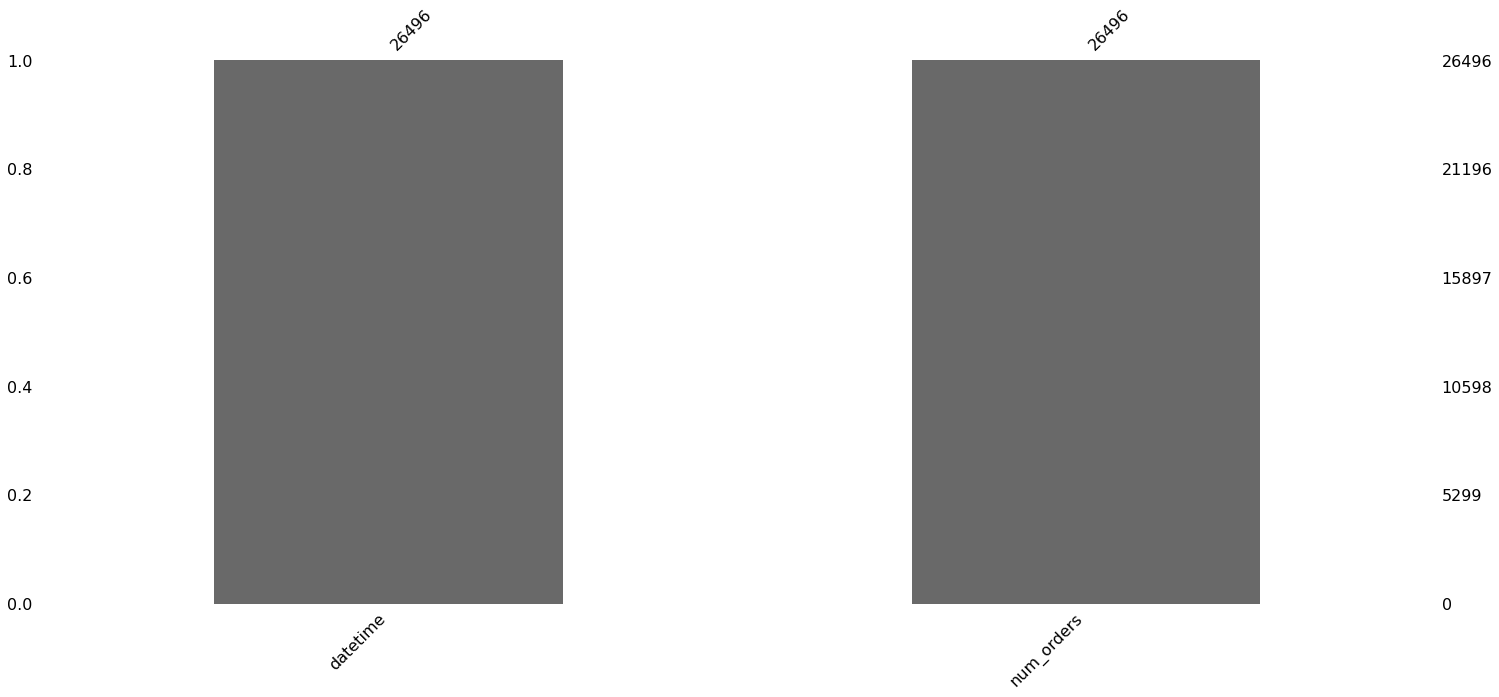

In [ ]:
msno.bar(data)

Данные загрузились нормально, пропусков и дубликатов нет. Посмотрим глубже.

## Анализ

Изменим формат на 'datetime64'

In [ ]:
data['datetime'] = data['datetime'].astype('datetime64')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


Код сработал

Проверим в хронологическом ли порядке расположены даты и время?

In [ ]:
data.set_index('datetime', inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
display(data.index.is_monotonic)
display(data.head())
data.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Если порядок соблюдён, атрибут вернёт True. Результат True, все нормально.

In [ ]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Сгруппируем значения по часу

In [ ]:
data = data.resample('1H').sum()


Построим графики.

<AxesSubplot:xlabel='datetime'>

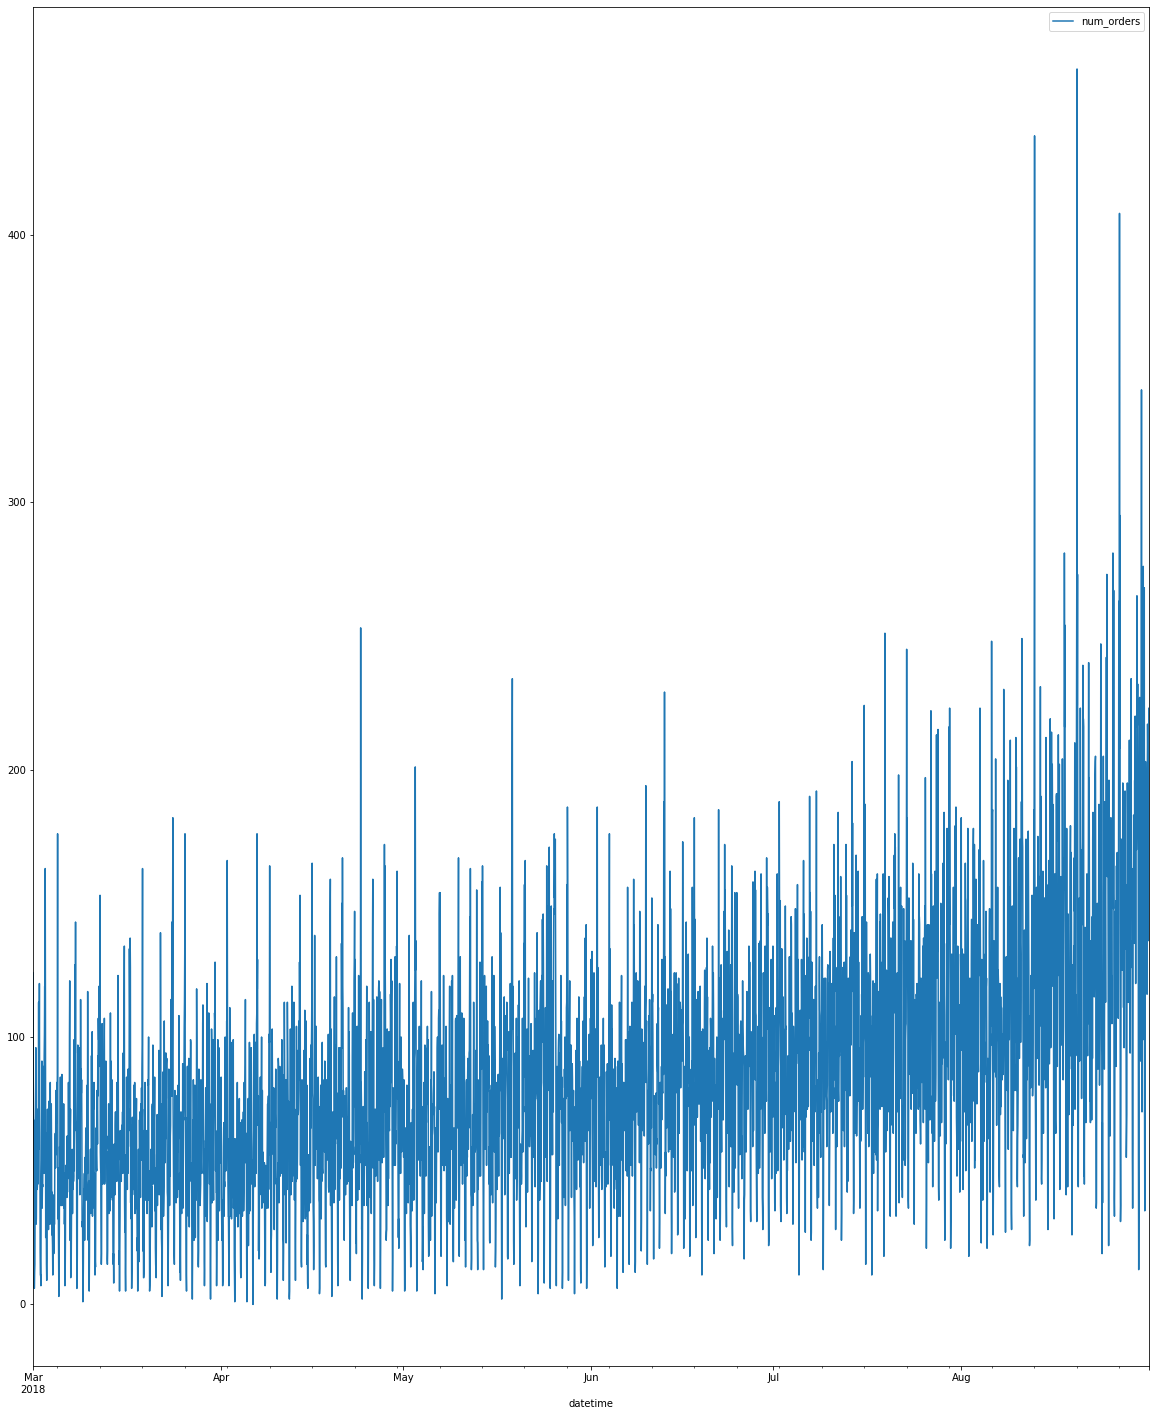

In [ ]:
data.plot(figsize=(20, 25))

<AxesSubplot:xlabel='datetime'>

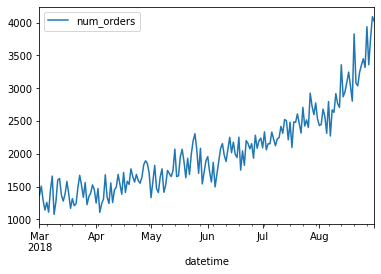

In [ ]:
data.resample('1D').sum().plot()

<AxesSubplot:xlabel='datetime'>

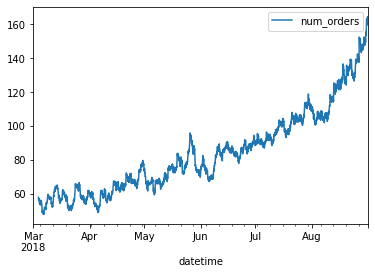

In [ ]:
data.rolling(70).mean().plot()

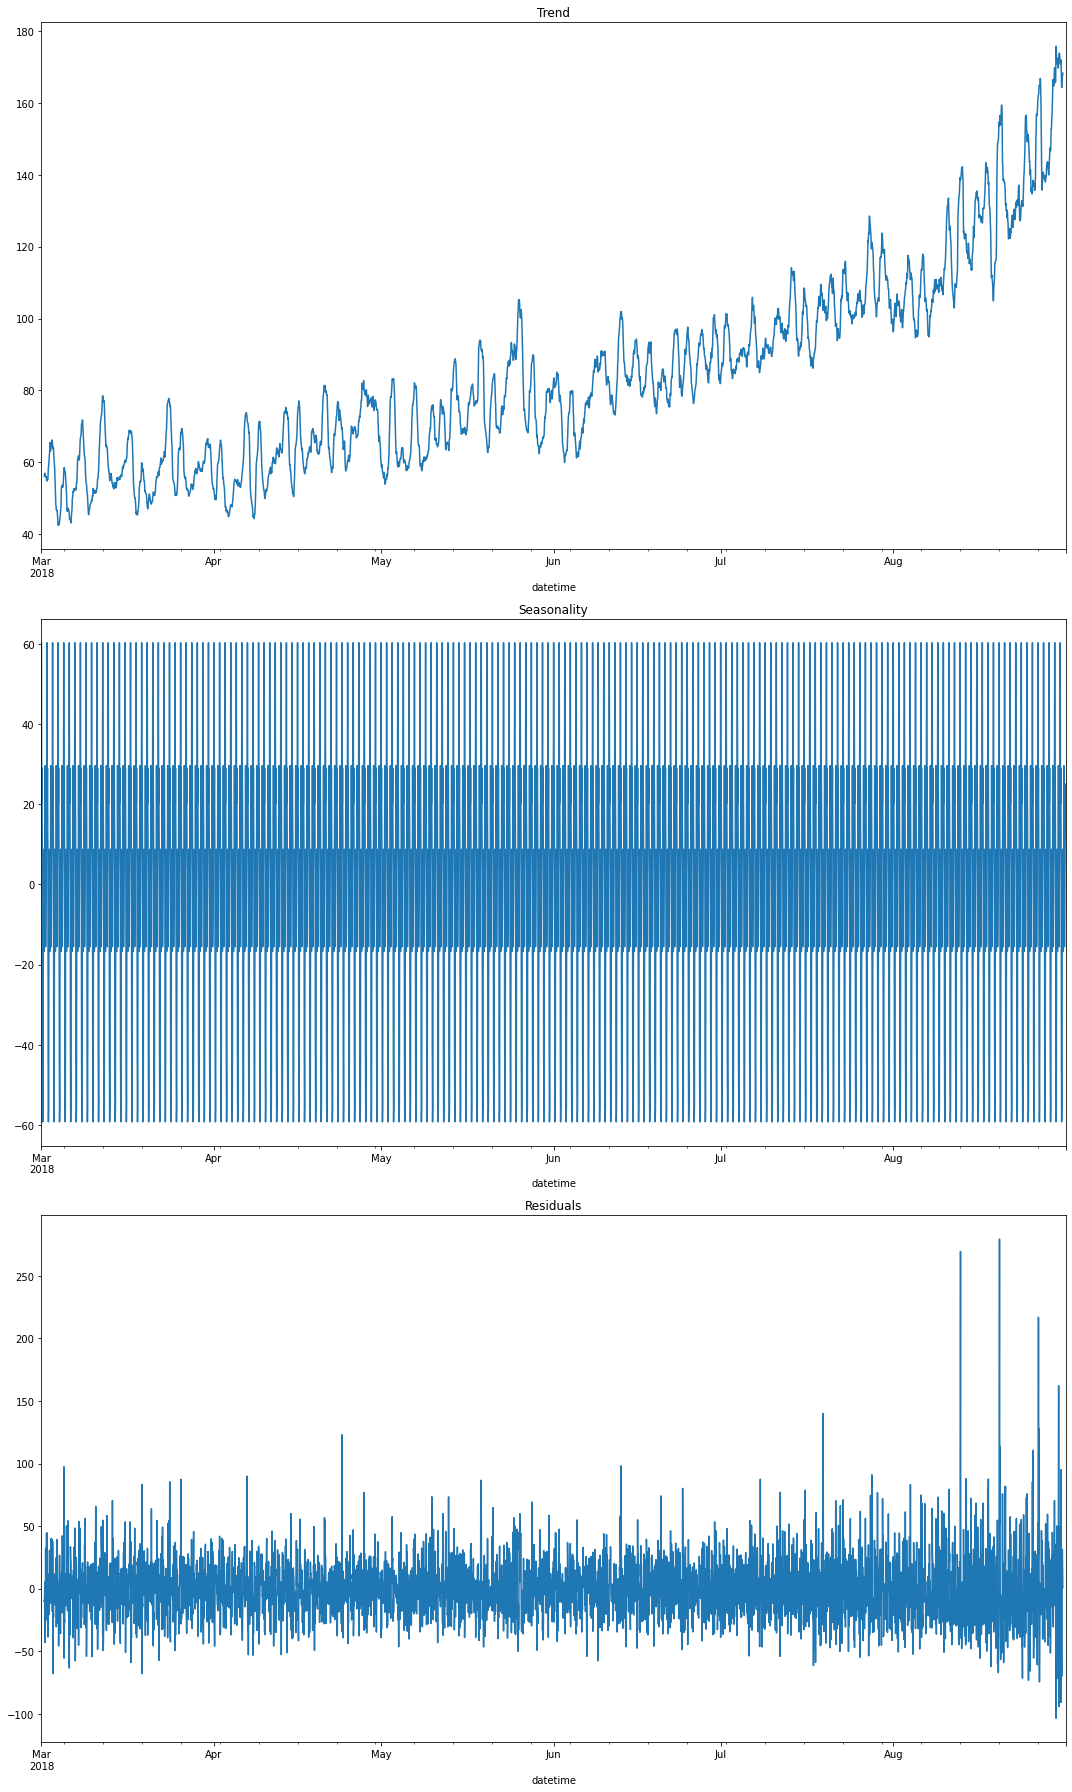

In [ ]:
decomposed = seasonal_decompose(data)  # < напишите код здесь >

plt.figure(figsize=(15, 25))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Явно просматривается тренд и сезонность. По заданию нужно предсказать колличество водителей на следующий час. Сократим наши данные до 1 недели плюс один день.

Text(0.5, 1.0, 'Residuals')

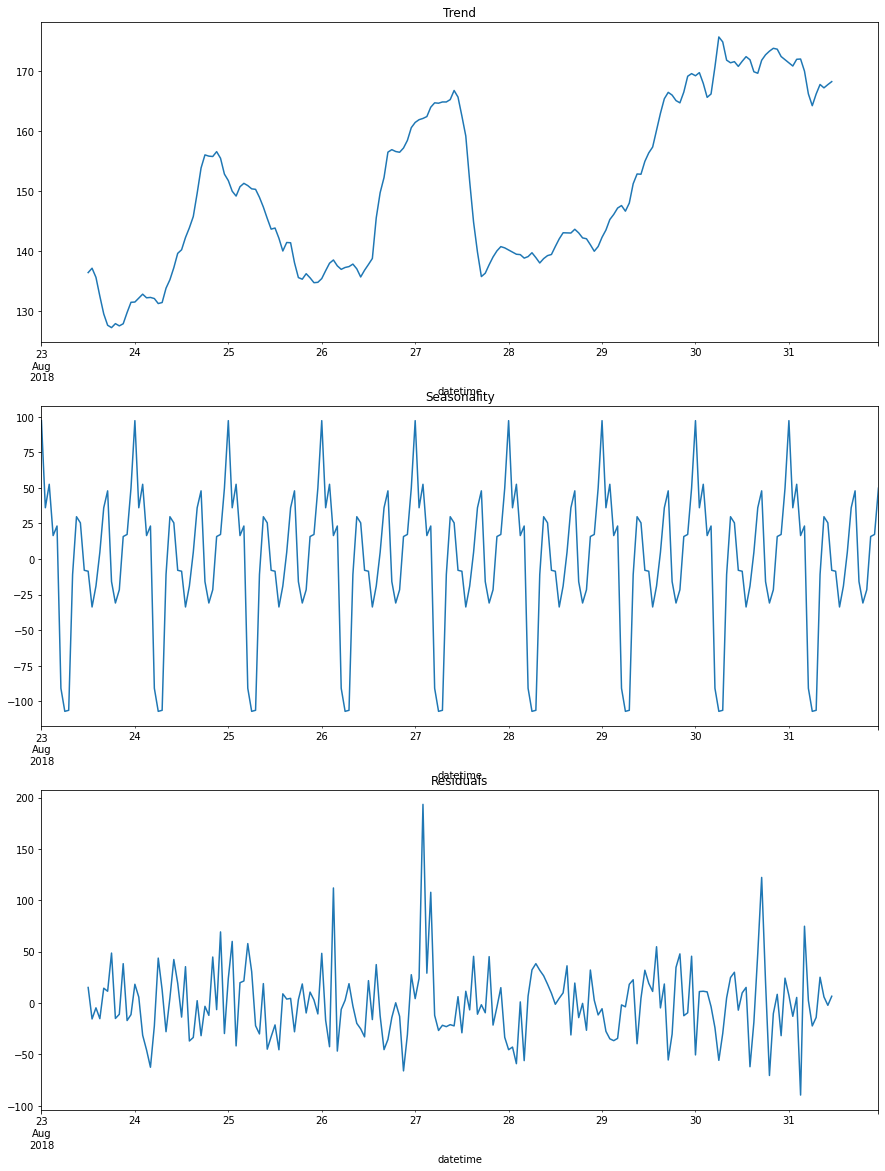

In [ ]:
decomposed = seasonal_decompose(data['2018-08-23':'2018-08-31'])

plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

за неделю тренд конечно не просматривается, но это нам и не надо. Видим сезонность по часам и неделям, все логично. Ночь и до утра мало кто пользуется такси, и большой прирос в вечернее время.

## Обучение

Функция для создания признаков, возмем день и неделю.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [ ]:
make_features(data, 168, 10)

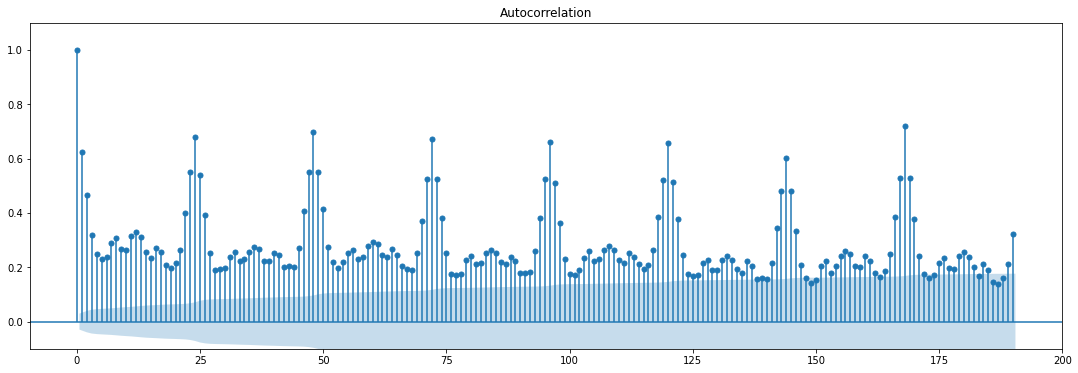

In [ ]:
import matplotlib.pyplot as plt

# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()



In [ ]:
#msno.bar(data)
data.isna().sum()

num_orders        0
dayofweek         0
hour              0
lag_1             1
lag_2             2
               ... 
lag_165         165
lag_166         166
lag_167         167
lag_168         168
rolling_mean     10
Length: 172, dtype: int64

Появились пропуски, логично. Удалим.

In [ ]:
data = data.dropna()

In [ ]:
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.2
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,84.2
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,86.9
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,88.8
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,90.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,173.3
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,166.6
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,162.9


In [ ]:
#msno.bar(data)
data.isna().sum()


num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
               ..
lag_165         0
lag_166         0
lag_167         0
lag_168         0
rolling_mean    0
Length: 172, dtype: int64

In [ ]:
# Проверим первые строки перед обучением.
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.2
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,84.2
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,86.9
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,88.8
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,90.8


Все хорошо, данные готовы. Можно приступать к разделению на выборки и обучению.

In [ ]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

Сделаем тестовую выборку размером 10% от исходных данных. По заданию.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False, random_state=12345)

In [ ]:
print('Обучающая выборка     _train', features_train.shape)
print('Тестовая выборка       _test', features_test.shape)

Обучающая выборка     _train (3823, 171)
Тестовая выборка       _test (425, 171)


так же будем проверять перед каждым обучением на хронологичность.

In [ ]:
display(features_train.index.is_monotonic)
display(features_train.head())

True

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.2
2018-03-08 01:00:00,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,84.2
2018-03-08 02:00:00,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,86.9
2018-03-08 03:00:00,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,88.8
2018-03-08 04:00:00,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,90.8


True - отлично, не нарушено

### Linear Regression Модель

In [ ]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring=scorer, verbose=True).fit(tf_idf_train, target_trai)
round(np.mean(-score_lr), 2)

На первый взгляд отличный результат. Но только на первый.

### RandomizedSearchCV

In [ ]:
display(features_train.index.is_monotonic)
#display(features_train.head())

True

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
RANDOM_STATE = 12345

In [ ]:
%%time
# Внимание!!! Долго запускается.

model = RandomForestRegressor()
param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv_rfr = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv_rfr, param_grid=param_search)
gsearch.fit(features_train, target_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

print(best_model)

RandomForestRegressor(max_depth=12, max_features='auto')

In [ ]:
%%time

model_rfr = RandomForestRegressor(max_depth=12, max_features='auto', random_state=12345)
model_rfr.fit(features_train, target_train)
score_rfr = cross_val_score(model_rfr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=10).split(features_train))
round(np.mean(-score_rfr), 2)

CPU times: user 2min 29s, sys: 129 ms, total: 2min 29s
Wall time: 2min 29s


22.0

Уже меньше. Посмотрим что покажет градиентный бустинг.

### LightGBM Модель (градиентный бустинг)

В отличии от предыдущей модели в данной для подбора гиперпараметров используем GridSearchCV

In [ ]:
display(features_train.index.is_monotonic)
#display(features_train.head())

True

In [ ]:
%%time

# Внимание!!! Долго запускается.


gbm = LGBMRegressor(boosting_type = 'gbdt', seed = RANDOM_STATE)
gbm_params = {'n_estimators': [20, 100], 'max_depth': [4,6]}

grid_gbm = GridSearchCV(estimator=gbm, param_grid= gbm_params, cv=tscv)
grid_gbm.fit(features_train, target_train);

print(grid_gbm.best_params_)

# {'max_depth': 4, 'n_estimators': 100}

In [ ]:
%%time

model_gbm = LGBMRegressor(max_depth = 4, n_estimators = 100, random_state=12345)
model_gbm.fit(features_train, target_train)
score_gbm = cross_val_score(model_gbm, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=10).split(features_train))
round(np.mean(-score_gbm), 2)


CPU times: user 5min 51s, sys: 3.56 s, total: 5min 55s
Wall time: 5min 56s


22.12

Практически такой же как и в Случайном лесе.

### CatBoost Regressor (градиентный бустинг)

In [ ]:
display(features_train.index.is_monotonic)
#display(features_train.head())

True

In [ ]:
%%time

cb = CatBoostRegressor(random_state=RANDOM)
cb_params = {'iterations':[10, 50], 'learning_rate': [0.1, 0.15, 0.25]}

grid_сb = GridSearchCV(cb, cb_params, cv=tscv)
grid_сb.fit(features_train, target_train,  verbose = False);

grid_сb.best_params_

# iterations': 50, 'learning_rate': 0.15

In [ ]:
%%time

model_cb = CatBoostRegressor(iterations = 50, learning_rate = 0.15, random_state=12345)
model_cb.fit(features_train, target_train)
score_cb = cross_val_score(model_cb, features_train, target_train, verbose = False, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=10).split(features_train))
round(np.mean(-score_cb), 2)

Лидер среди наших моделей. Тогда данную модель и возмем для теста.

### Таблица RMSE

In [ ]:
final_analysis = [[round(np.mean(-score_lr), 2)],
        [round(np.mean(-score_rfr), 2)],
        [round(np.mean(-score_gbm), 2)],
        [round(np.mean(-score_cb), 2)]]

model_name = ["Linear Regression", "Random Forest Regressor", "LGBM Regressor", "CatBoost Regressor"]

In [ ]:
pd.DataFrame(data = final_analysis, index = model_name, columns=["RMSE"])

,RMSE
Linear Regression,23.44
Random Forest Regressor,22.00
LGBM Regressor,22.12
CatBoost Regressor,21.97


И так подведем итог. По заданю нам нужно было найти лучшую модель с RMSE менее 48. С данной задачей справились все модели. Но  LightGBM Модель (градиентный бустинг) справился лучше всего, показав наименьший результат. Ее и протестируем.

## Тестирование

In [ ]:
display(features_test.index.is_monotonic)
#display(features_test.head())

True

In [ ]:
preds_cb_model_test = model_cb.predict(features_test)

In [ ]:
rmse_cb_test = np.sqrt(mean_squared_error(target_test, preds_cb_model_test))
print(f'RMSE для LightGBM: {rmse_cb_test.round(1)}')

RMSE для LightGBM: 39.9


RMSE на тесте больше, но меньше чем в задании. С задачей справились, проверим на адекватность.

### Проверим на адекватность

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

pred_previous.head(6)

datetime
2018-08-14 07:00:00     45.0
2018-08-14 08:00:00     54.0
2018-08-14 09:00:00     91.0
2018-08-14 10:00:00    135.0
2018-08-14 11:00:00    155.0
2018-08-14 12:00:00    162.0
Freq: H, Name: num_orders, dtype: float64

In [ ]:
target_test.head()

datetime
2018-08-14 07:00:00     54
2018-08-14 08:00:00     91
2018-08-14 09:00:00    135
2018-08-14 10:00:00    155
2018-08-14 11:00:00    162
Freq: H, Name: num_orders, dtype: int64

Похоже что модель адекватна.

In [ ]:

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_const = np.sqrt(mean_squared_error(target_test, pred_previous))
print(f'RMSE для LightGBM: {rmse_const.round(1)}')

RMSE для LightGBM: 58.8


### Вывод

Мы проделали большой объем работы. Первым делом мы проанализировали предоставленные данные, пропусков нет, дубликатов тоже нет, хронология не нарушена. Далее проведен анализ предоставленных данных, были сделаны определенные выводы, хорошо просматривается общий тренд, так же сезонность в течении недели и дня, что в принципе логично. В третьем пункте мы добавили признаки для обучения наших будущих моделей. По заданию нам нужно было сделать тестовую выборку 10%, что мы и выполнили. Для обучения, традиционно взяли четыре модели "Linear Regression", "Random Forest Regressor", "LGBM Regressor", "CatBoost Regressor". Все модели показали хороший результат, самый минимальный RMSE у CatBoost 39.9. При тестировании CatBoost Модель так же показала удовлетворяющий нас результат. А именно меньше 48, ее мы можем рекомендовать для использования в данных задачах, так же модель прошла проверку на адекватность.

С уважением,

А. Нестеров

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48